
# 🎥 Fase 1 — Coleta de Comentários do YouTube  
**Projeto:** Mineração de Textos — Análise de Sentimentos  
**CRISP-DM:** Data Acquisition / Data Understanding  

Este notebook coleta comentários de **um canal (vários vídeos)** ou de **um vídeo específico** do YouTube, de forma **parametrizada** (sem `input()`), pronta para integrar em Flask.


In [1]:

# ============================================================
# 1) Importações e Configurações
# ============================================================
from googleapiclient.discovery import build
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import re, os, time
from langdetect import detect, DetectorFactory

# Reprodutibilidade para langdetect
DetectorFactory.seed = 0

# Carregar .env
load_dotenv()
API_KEY = os.getenv("YOUTUBE_API_KEY")

# Cliente YouTube
youtube = build("youtube", "v3", developerKey=API_KEY)

# Parâmetros padrão (altere aqui ou passe via Flask futuramente)
ENTRADA = os.getenv("YTB_INPUT", "https://www.youtube.com/@YouTubeCreators")
MAX_VIDEOS = int(os.getenv("MAX_VIDEOS", 5))           # somente quando ENTRADA for canal
MAX_COMMENTS = int(os.getenv("MAX_COMMENTS", 1000))    # por vídeo (canal ou vídeo único)
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "data")

print("✅ Bibliotecas carregadas e cliente YouTube pronto.")

✅ Bibliotecas carregadas e cliente YouTube pronto.


In [2]:

# ============================================================
# 2) Utilitários: identificação e parsing da entrada
# ============================================================
import re

def identificar_tipo_entrada(url_ou_id: str) -> str:
    url = url_ou_id.strip()
    # Vídeo (URL watch) ou ID de 11 chars
    if "watch?v=" in url:
        return "video"
    if re.fullmatch(r"[A-Za-z0-9_-]{11}", url):
        return "video"
    # Canal (por ID, handle ou outras variações)
    if "/channel/" in url or "/@" in url:
        return "canal"
    # fallback: tentaremos resolver como canal por busca
    return "canal"

def extrair_video_id(token: str) -> str:
    if "watch?v=" in token:
        m = re.search(r"[?&]v=([A-Za-z0-9_-]{11})", token)
        if m:
            return m.group(1)
    if re.fullmatch(r"[A-Za-z0-9_-]{11}", token):
        return token
    raise ValueError("Não foi possível extrair o video_id da entrada fornecida.")

def resolver_channel_id(youtube, entrada: str) -> str:
    url = entrada.strip()
    # /channel/CHANNEL_ID
    m = re.search(r"/channel/([A-Za-z0-9_-]+)", url)
    if m:
        return m.group(1)

    # Handle: /@handle  -> buscar pelo handle como canal
    m = re.search(r"youtube\.com/@([^/?]+)", url)
    if m:
        handle = "@" + m.group(1)
        resp = youtube.search().list(part="snippet", q=handle, type="channel", maxResults=1).execute()
        items = resp.get("items", [])
        if items:
            return items[0]["snippet"]["channelId"]

    # Caso seja um nome /c/<custom> ou texto avulso, tentar busca por canal (fallback)
    query = re.sub(r"https?://(www\.)?youtube\.com/+", " ", url)
    resp = youtube.search().list(part="snippet", q=query, type="channel", maxResults=1).execute()
    items = resp.get("items", [])
    if items:
        return items[0]["snippet"]["channelId"]

    raise ValueError("Não foi possível resolver o channel_id a partir da entrada.")

In [3]:

# ============================================================
# 3) Coleta de comentários com paginação
# ============================================================
def extrair_comentarios(video_id: str, max_comments: int = 1000):
    comentarios, token = [], None
    try:
        while True and len(comentarios) < max_comments:
            resp = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=100,
                textFormat="plainText",
                pageToken=token
            ).execute()

            for item in resp.get("items", []):
                txt = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
                comentarios.append(txt)
                if len(comentarios) >= max_comments:
                    break

            token = resp.get("nextPageToken")
            if not token or len(comentarios) >= max_comments:
                break
            time.sleep(0.3)  # leve respeito à API
    except Exception as e:
        print(f"⚠️ Erro ao coletar comentários do vídeo {video_id}: {e}")
    return comentarios

def titulo_do_video(video_id: str) -> str:
    try:
        resp = youtube.videos().list(part="snippet", id=video_id, maxResults=1).execute()
        items = resp.get("items", [])
        if items:
            return items[0]["snippet"]["title"]
    except Exception:
        pass
    return "Vídeo específico"  # fallback

In [4]:

# ============================================================
# 4) Coleta por canal (top N vídeos por viewCount) e por vídeo
# ============================================================
def coletar_comentarios_canal(entrada_canal: str, max_videos: int = 5, max_comments: int = 1000):
    channel_id = resolver_channel_id(youtube, entrada_canal)
    search = youtube.search().list(
        part="id,snippet",
        channelId=channel_id,
        maxResults=max_videos,
        order="viewCount",
        type="video"
    ).execute()

    dados = []
    for it in search.get("items", []):
        vid = it["id"]["videoId"]
        titulo = it["snippet"]["title"]
        coments = extrair_comentarios(vid, max_comments=max_comments)
        for c in coments:
            try:
                idioma = detect(c)
            except Exception:
                idioma = "indefinido"
            dados.append({
                "video_id": vid,
                "video_titulo": titulo,
                "comentario": c,
                "idioma": idioma,
                "data_coleta": pd.Timestamp.now().strftime("%Y-%m-%d")
            })
    return pd.DataFrame(dados)

def coletar_comentarios_video(entrada_video: str, max_comments: int = 1000):
    vid = extrair_video_id(entrada_video)
    titulo = titulo_do_video(vid)
    coments = extrair_comentarios(vid, max_comments=max_comments)

    dados = []
    for c in coments:
        try:
            idioma = detect(c)
        except Exception:
            idioma = "indefinido"
        dados.append({
            "video_id": vid,
            "video_titulo": titulo,
            "comentario": c,
            "idioma": idioma,
            "data_coleta": pd.Timestamp.now().strftime("%Y-%m-%d")
        })
    return pd.DataFrame(dados)

In [5]:

# ============================================================
# 5) Função unificada: decide automaticamente canal vs vídeo
# ============================================================
def iniciar_coleta(entrada: str, max_videos: int = 5, max_comments: int = 1000, output_dir: str = "data"):
    tipo = identificar_tipo_entrada(entrada)
    print(f"▶️ Entrada detectada como: {tipo.upper()}")
    if tipo == "canal":
        df = coletar_comentarios_canal(entrada, max_videos=max_videos, max_comments=max_comments)
    else:
        df = coletar_comentarios_video(entrada, max_comments=max_comments)

    # Pós-processamento
    df.drop_duplicates(inplace=True)
    os.makedirs(output_dir, exist_ok=True)
    ts = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    out_path = os.path.join(output_dir, f"comentarios_coletados_{ts}.csv")
    df.to_csv(out_path, index=False, encoding="utf-8-sig")

    print(f"✅ Coleta concluída: {len(df)} comentários")
    print(f"📦 Arquivo salvo: {out_path}")
    return df, out_path

In [6]:

# ============================================================
# 6) Execução (parametrizada, sem input())
# ============================================================
df_coleta, arquivo_coletado = iniciar_coleta(
    ENTRADA,
    max_videos=MAX_VIDEOS,
    max_comments=MAX_COMMENTS,
    output_dir=OUTPUT_DIR
)

print("\nPrévia dos dados:")
display(df_coleta.head(10))

▶️ Entrada detectada como: CANAL
✅ Coleta concluída: 4371 comentários
📦 Arquivo salvo: data\comentarios_coletados_20251023_191025.csv

Prévia dos dados:


,video_id,video_titulo,comentario,idioma,data_coleta
0,VKf6NF0OD5A,The new and improved YouTube Studio is here,Check out the entire series on how to use YouT...,en,2025-10-23
1,VKf6NF0OD5A,The new and improved YouTube Studio is here,Nice,ro,2025-10-23
2,VKf6NF0OD5A,The new and improved YouTube Studio is here,मेरा चैनल पर 100k सब्सक्राइबर है अभी तक सिल्व...,hi,2025-10-23
3,VKf6NF0OD5A,The new and improved YouTube Studio is here,❤❤❤❤❤,indefinido,2025-10-23
4,VKf6NF0OD5A,The new and improved YouTube Studio is here,Good❤❤❤❤ 0:25,so,2025-10-23
5,VKf6NF0OD5A,The new and improved YouTube Studio is here,Nice❤❤❤❤❤ 0:14,ro,2025-10-23
6,VKf6NF0OD5A,The new and improved YouTube Studio is here,Great tips 💯,en,2025-10-23
7,VKf6NF0OD5A,The new and improved YouTube Studio is here,vreri nice . 😮😮😅,hr,2025-10-23
8,VKf6NF0OD5A,The new and improved YouTube Studio is here,Great information 👌🏻👌🏻thanks you tube🙏🏻,en,2025-10-23
9,VKf6NF0OD5A,The new and improved YouTube Studio is here,Thanks for 200 subscribers 😊,en,2025-10-23



📊 Estatísticas do tamanho dos comentários:
count    4371.00000
mean       37.06383
std        87.10579
min         0.00000
25%         9.00000
50%        20.00000
75%        39.00000
max      3282.00000
Name: tamanho, dtype: float64


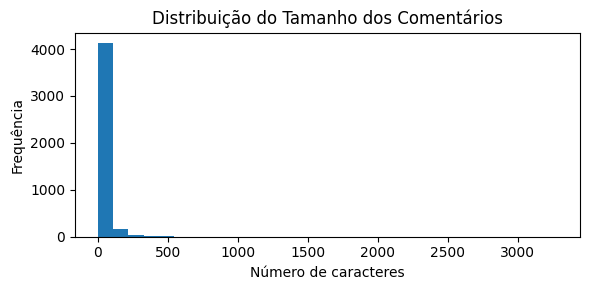

In [7]:

# ============================================================
# 7) EDA básica (sanidade da coleta)
# ============================================================
if not df_coleta.empty:
    df_coleta['tamanho'] = df_coleta['comentario'].astype(str).str.len()
    print("\n📊 Estatísticas do tamanho dos comentários:")
    print(df_coleta['tamanho'].describe())

    plt.figure(figsize=(6,3))
    df_coleta['tamanho'].plot(kind='hist', bins=30)
    plt.title("Distribuição do Tamanho dos Comentários")
    plt.xlabel("Número de caracteres")
    plt.ylabel("Frequência")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Nenhum comentário coletado. Verifique a entrada e as permissões da API.")
